In [90]:
%load_ext autoreload
%autoreload 2
from rdkit import Chem
from rdkit.Chem import Draw
from accfg import (AccFG, draw_mol_with_fgs, molimg, 
                   img_grid,  compare_mols, draw_compare_mols,
                   draw_RascalMCES, print_fg_tree)

from IPython.display import Image
import networkx as nx

afg_lite = AccFG(print_load_info=True, lite=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded 231 common functional groups (lite). Loaded 195 heterocycle groups. Total 426 functional groups loaded.


In [36]:
fg,graph = afg_lite.run('C=NOC=O',show_graph=True)
print_directed_graph_as_tree(graph,fg.keys())

├──Oxim-ester
│  ├──oxy
│  ├──Carbonyl
│  ├──Aldehyde
│  └──Carboxylic ester
│     ├──oxy
│     ├──Carbonyl
│     └──Aldehyde


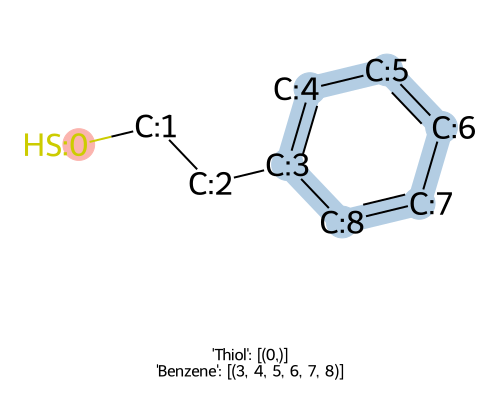

In [37]:
molimg(draw_mol_with_fgs('SCCc1ccccc1',afg_lite))

In [99]:
smi_1,smi_2 = ('N#CCNC(=O)[C@@H]1CCCC[C@H]1C(=O)N1CCc2ccccc2C1', 'N#CCNC(=O)[C@@H]1CCCC[C@H]1C(=O)N1CCN(c2ccccc2)CC1')
#smi_1,smi_2 = ('CC(=O)NC[C@H]1CN(c2ccc(-n3ccc(C#N)c3)c(F)c2)C(=O)O1','CC(=O)NC[C@H]1CN(c2ccc(N3CCN(c4ccc(C#N)cn4)CC3)c(F)c2)C(=O)O1')
smi_1, smi_2 = ('CC(=O)CCCC(C)C(=O)O','O=C(O)CCCCC(=O)O')
smi_1, smi_2 = ('OC(=O)CC(C)CCCCCC(=O)O','CCCCCCC')
# smi_1,smi_2 = ('CNC(=O)Cc1nc(-c2ccccc2)cs1','CCNCCc1nc2ccccc2s1')
compare_mols(smi_1, smi_2, afg_lite)

/home/xuan/GitLab/AccFG_private/accfg/main.py:414: UserWarning: target_smiles: CC(CCCCCC(=O)O)CC(=O)O and ref_smiles: CCCCCCC has low similarity. MCES result is empty. Try to lower the similarityThreshold.
  warnings.warn(f'target_smiles: {target_smiles} and ref_smiles: {ref_smiles} has low similarity. MCES result is empty. Try to lower the similarityThreshold.')


(([('Carboxylic acid', 2, [(7, 8, 9), (11, 12, 13)])],
  [('C1 alkane', 1, [[0]])]),
 ([], []))

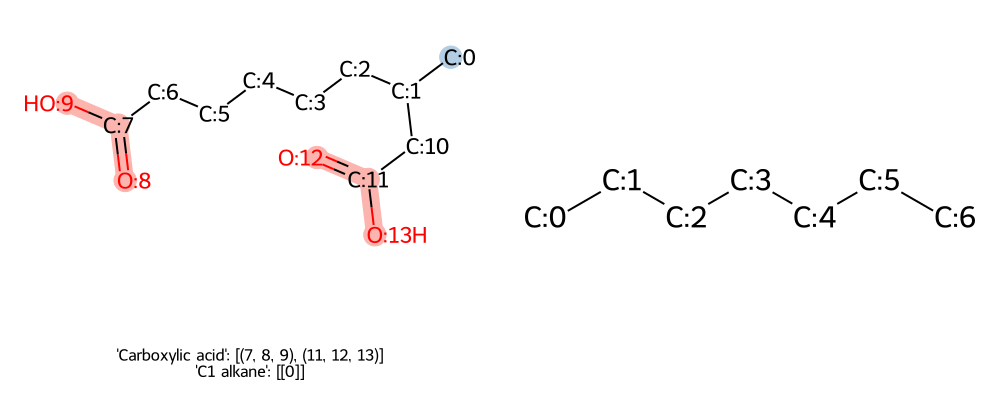

In [100]:
img_grid(draw_compare_mols(smi_1, smi_2, afg_lite),num_columns=2)

In [93]:
from collections import defaultdict, namedtuple
def get_neighbors(atom):
    ''' test all mapped neighbors of a mapped atom'''
    res = defaultdict(list)
    atom_idx = atom.GetIdx()
    for nbr in atom.GetNeighbors():
        nbr_idx = nbr.GetIdx()
        res[atom_idx].append(nbr_idx) 
    return res

def get_outer_bonds(nbr_result):
    inner_atoms = set(nbr_result.keys())
    outer_bonds = []
    for atom_idx, nbrs in nbr_result.items():
        for nbr in nbrs:
            if nbr not in inner_atoms:
                outer_bonds.append((atom_idx,nbr))
    return outer_bonds

FGInfo = namedtuple('FGInfo',['fg_name','fg_atoms','outer_bond_list'])

def extract_fg_info(mol, unique_target_fgs_atoms):
    target_fg_info = []
    for fg, _, atom_list in unique_target_fgs_atoms:
        for atoms in atom_list:
            nbr_result = {}
            for atom in atoms:  # get neighbors
                nbr_result.update(get_neighbors(mol.GetAtomWithIdx(atom)))
            outer_bonds = get_outer_bonds(nbr_result)
            target_fg_info.append(FGInfo(fg, atoms, outer_bonds))
    return target_fg_info


In [101]:
from accfg import remove_atoms_from_mol, canonical_smiles, set_atom_idx

smi_1 = canonical_smiles(smi_1)
smi_2 = canonical_smiles(smi_2)
compare_result = compare_mols(smi_1, smi_2, afg_lite)
mol_1 = Chem.MolFromSmiles(smi_1)
mol_2 = Chem.MolFromSmiles(smi_2)
mol_1 = set_atom_idx(mol_1,'atomNote')
mol_2 = set_atom_idx(mol_2,'atomNote')
(unique_target_fgs_atoms, target_remain_alkane), (unique_ref_fgs_atoms, ref_remain_alkane) = compare_result

target_fg_info = extract_fg_info(mol_1, unique_target_fgs_atoms) + extract_fg_info(mol_1, target_remain_alkane)
print(target_fg_info)

[FGInfo(fg_name='Carboxylic acid', fg_atoms=(7, 8, 9), outer_bond_list=[(7, 6)]), FGInfo(fg_name='Carboxylic acid', fg_atoms=(11, 12, 13), outer_bond_list=[(11, 10)]), FGInfo(fg_name='C1 alkane', fg_atoms=[0], outer_bond_list=[(0, 1)])]


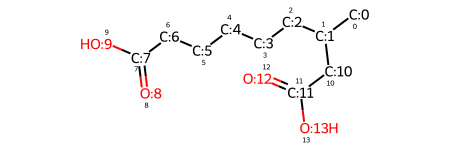

In [106]:
mol_1

In [105]:
Chem.MolToSmiles(set_atom_idx(mol_1,'molAtomMapNumber'))

'[CH3:0][CH:1]([CH2:2][CH2:3][CH2:4][CH2:5][CH2:6][C:7](=[O:8])[OH:9])[CH2:10][C:11](=[O:12])[OH:13]'

In [70]:
from accfg import compare_mols
smiles_list =[#('CC(=O)NC[C@H]1CN(c2ccc(-n3ccc(C#N)c3)c(F)c2)C(=O)O1','CC(=O)NC[C@H]1CN(c2ccc(N3CCN(c4ccc(C#N)cn4)CC3)c(F)c2)C(=O)O1'),
              #('Cc1cc2n[nH]c(=O)n2c2cc(-c3ccc[nH]3)ccc12', 'Cc1cc2n[nH]c(=O)n2c2ccccc12'), 
              #('CCOc1cccc(Nc2nnc(C(=O)Nc3ccc(N4CCOCC4)nc3)o2)c1', 'O=C(Nc1ccc(N2CCOCC2)nc1)c1nnc(Nc2cccc(OCc3cccnc3)c2)o1'),
              #('CCN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(CCC(c2ccccc2)c2ccccc2)CC1', 'CCN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(CCC(c2ccccc2)N2CCN(c3ccccc3)CC2)CC1'),
              #('CNC(=O)Cc1nc(-c2ccccc2)cs1','CCNCCc1nc2ccccc2s1')
              ]
for smi_1, smi_2 in smiles_list:
    print(compare_mols(smi_1, smi_2))

In [75]:
smi_1,smi_2 = ('CNC(=O)Cc1nc(-c2ccccc2)cs1','CCNCCc1nc2ccccc2s1')
compare_mols(smi_1, smi_2)

target_remain_mol: C.C
ref_remain_mol: CC.CC
target_remain_mol_frags: ((0,), (1,))
ref_remain_mol_frags: ((0, 1), (2, 3))


/home/xuan/GitLab/AccFG/accfg/main.py:592: UserWarning: Using loose method to get the remaining alkanes.


(([('Secondary amide', 1, [(2, 3, 1)]),
   ('Benzene', 1, [(8, 9, 10, 11, 12, 13)]),
   ('thiazole', 1, [(7, 14, 15, 5, 6)])],
  []),
 ([('Secondary aliphatic amine', 1, [(2,)]),
   ('benzo[d]thiazole', 1, [(9, 10, 11, 12, 13, 5, 6, 7, 8)])],
  [('C1 alkane', 1, [[0]])]))

In [122]:
def get_mapped_neighbors(atom):
    ''' test all mapped neighbors of a mapped atom'''
    res = {}
    amap = atom.GetAtomMapNum()
    if not amap:
        return res
    for nbr in atom.GetNeighbors():
        nmap = nbr.GetAtomMapNum()
        if nmap:
            if amap>nmap:
                res[(nmap,amap)] = (atom.GetIdx(),nbr.GetIdx())
            else:
                res[(amap,nmap)] = (nbr.GetIdx(),atom.GetIdx())
    return res

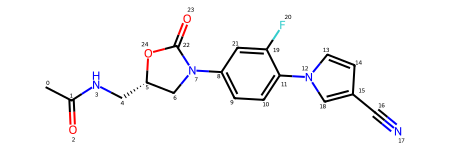

In [233]:
target_mol

In [124]:
for fg, _, fg_atom_list in unique_target_fgs_atoms:
    print(fg_atom_list)
    for atom_list in fg_atom_list:
        for atom_index in atom_list:
            atom = target_mol.GetAtomWithIdx(atom_index)
            print(get_mapped_neighbors(atom))

[(1, 2)]
{(1, 2): (2, 1), (1, 3): (3, 1)}
{(1, 2): (2, 1)}


In [48]:
res_on_remain = get_RascalMCES(target_remain_mol, ref_remain_mol)
res_on_remain[0].atomMatches()

[(1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7, 6)]

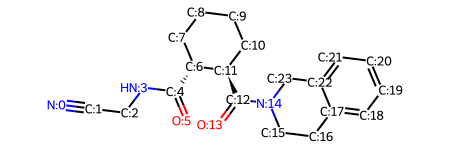

In [30]:
mol_1 = show_atom_idx(smi_1)
mol_1

In [35]:
smarts = Chem.MolToSmarts(mol_1)
print(smarts)
smiles = Chem.MolToSmiles(mol_1)
print(smiles)

[#7:0]#[#6:1]-[#6:2]-[#7:3]-[#6:4](=[#8:5])-[#6@@H:6]1-[#6:7]-[#6:8]-[#6:9]-[#6:10]-[#6@H:11]-1-[#6:12](=[#8:13])-[#7:14]1-[#6:15]-[#6:16]-[#6:17]2:[#6:18]:[#6:19]:[#6:20]:[#6:21]:[#6:22]:2-[#6:23]-1
[N:0]#[C:1][CH2:2][NH:3][C:4](=[O:5])[C@@H:6]1[CH2:7][CH2:8][CH2:9][CH2:10][C@H:11]1[C:12](=[O:13])[N:14]1[CH2:15][CH2:16][c:17]2[cH:18][cH:19][cH:20][cH:21][c:22]2[CH2:23]1


In [36]:
afg.run(smi_1)

{'Secondary amide': [(4, 5, 3, 2)],
 'Tertiary amide': [(12, 13, 14, 15, 23)],
 'Nitrile': [(0, 1)],
 'Benzene': [(17, 18, 19, 20, 21, 22)]}